In [1]:
%matplotlib widget

import yt
import numpy as np
from yt import SlicePlot
from yt import ProjectionPlot
from yt.units import *
import matplotlib.pyplot as plt
from yt.visualization.fixed_resolution import FixedResolutionBuffer
from matplotlib import colors
from matplotlib.colors import LogNorm

In [2]:
'''
Select a snapshot from 0-454
'''

snap = 130



hd_path = '/u/kneralwar/ptmp_link/starforge/M2e4_alpha2_fiducial/'
ds = yt.load(hd_path + 'snapshot_' + str(snap).zfill(3) +'.hdf5', unit_base = {'UnitMagneticField_in_gauss':  1e+4,
             'UnitLength_in_cm'         : 3.08568e+18,
             'UnitMass_in_g'            :   1.989e+33,
             'UnitVelocity_in_cm_per_s' :      100})

dust_to_gas = 0.01
mol_hydrogen_ratio = 2.0
microturbulence_speed = 1e4 # cgs
gamma = 5.0/3.0 # Note gamma is not constant and this function is an approximation.
helium_mass_fraction = 0.284 # Default mass fraction in Gizmo

# number fraction of target species
molecular_abundance = 1.5 * 10**-6 # abundance of 13CO # for now : AS per casi 3d paper. old assumption: We consider that the gas is H2 and then obtain the 13CO abundance using the $\frac{12C}{13C}$ = 60 and $\frac{CO}{H2}$ = 10$^{-4}$ factors specified in SEDIGISM 2017 paper.

# Mask abundance based on accreted particles
mask_abundance = False


def _gas_temp(field, data):
    try:
        if data[("PartType0", "Temperature")].units == (dimensionless):
            return (data[('PartType0','Temperature')] * K) * (data[('PartType0','Temperature')] < yt.YTArray([3e3]))
        else:
            return ((data[('PartType0','Temperature')]) * 1e-6 * (data[('PartType0','Temperature')] < yt.YTArray([3e9])))

    except:
        y_helium = helium_mass_fraction / (
            4.0 * (1 -helium_mass_fraction)
        )
        mu = (1 + 4.0 * y_helium) / (1 + y_helium)
        const = (mu * mh.in_mks() * (gamma - 1)) / (1e6 * kboltz.in_mks())
        return (
            data[("PartType0", "InternalEnergy")]
            * const
            * (data[("PartType0", "InternalEnergy")] < yt.YTArray([3e3], "K") / const)
        )

def _rmsvel_cms(field,data):
    vel_x = data['PartType0','velocity_x']
    vel_y = data['PartType0','velocity_y']
    vel_z = data['PartType0','velocity_z']
    return (np.sqrt(vel_x**2 + vel_y**2 + vel_z**2))

def _m11(field,data):
    m11 = data['PartType0', 'Metallicity_11']
    m12 = data['PartType0', 'Metallicity_12']
    m13 = data['PartType0', 'Metallicity_13']
    return (m11/(1-m12-m13))

def _m12(field,data):
    m11 = data['PartType0', 'Metallicity_11']
    m12 = data['PartType0', 'Metallicity_12']
    m13 = data['PartType0', 'Metallicity_13']
    return (m12/(1-m11-m13))

def _m13(field,data):
    m11 = data['PartType0', 'Metallicity_11']
    m12 = data['PartType0', 'Metallicity_12']
    m13 = data['PartType0', 'Metallicity_13']
    return (m13/(1-m12-m11))


def _H2NumDensity(field, data):
    return data[('PartType0', 'Density')]*data[('PartType0', 'MolecularMassFraction')]*data[('PartType0', 'NeutralHydrogenAbundance')]*(1-helium_mass_fraction)/(mol_hydrogen_ratio*mh)

def _MolecularNumDensity(field, data):
    return (data[('PartType0', 'H2NumDensity')])*molecular_abundance*(data[('PartType0','H2NumDensity')] < yt.YTArray([1e4], "cm**-3"))*( data[('PartType0','gas_temperature')] < yt.YTArray([3e3], "K"))*( np.abs(data[('PartType0','vel_kms')]) < yt.YTArray([5e6], "cm/s"))*( data[('PartType0','gas_temperature')] > yt.YTArray([0], "K"))


'''
Creating a masked molecular number density that represents only the density with gas above a certain feedback fraction.
'''
def _MaskedMolecularNumDensity(field, data):
    return (data[('PartType0', 'H2NumDensity')])*molecular_abundance*(data[('PartType0','H2NumDensity')] < yt.YTArray([1e4], "cm**-3"))*( data[('PartType0','gas_temperature')] < yt.YTArray([3e3], "K"))*( np.abs(data[('PartType0','vel_kms')]) < yt.YTArray([5e6], "cm/s"))*( data[('PartType0','gas_temperature')] > yt.YTArray([20], "K")) * (data[('PartType0', 'Metallicity_11')] > yt.YTArray([0.1], ""))


ds.add_field(("PartType0", "gas_temperature"), function=_gas_temp, units="K", sampling_type='particle', force_override=True)

ds.add_field(("PartType0", "vel_cms"), function=_rmsvel_kms, units="cm/s", sampling_type='particle', force_override=True)

ds.add_field(("PartType0", "m_11"), function=_m11, units="", sampling_type='particle', force_override=True)

ds.add_field(("PartType0", "m_12"), function=_m12, units="", sampling_type='particle', force_override=True)

ds.add_field(("PartType0", "m_13"), function=_m13, units="", sampling_type='particle', force_override=True)

ds.add_field(('PartType0', 'H2NumDensity'), function=_H2NumDensity, units='cm**-3', sampling_type='particle', force_override=True)

ds.add_field(('PartType0', 'MolecularNumDensity'), function=_MolecularNumDensity, units='cm**-3', sampling_type='particle', force_override=True)

ds.add_field(('PartType0', 'MaskedMolecularNumDensity'), function=_MaskedMolecularNumDensity, units='cm**-3', sampling_type='particle', force_override=True)

print('Done')

yt : [INFO     ] 2024-05-31 14:51:23,199 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2024-05-31 14:51:23,267 Parameters: current_time              = 0.003282081812504891
yt : [INFO     ] 2024-05-31 14:51:23,269 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-05-31 14:51:23,271 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-05-31 14:51:23,272 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2024-05-31 14:51:23,274 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-05-31 14:51:23,362 Allocating for 2.458e+07 particles
Loading particle index: 100%|██████████| 94/94 [00:00<00:00, 853.18it/s]


Done


## Trial for m11 with vel cut off

In [16]:
def _m11_v10(field,data):
    m11 = data['PartType0', 'Metallicity_11']
    m12 = data['PartType0', 'Metallicity_12']
    m13 = data['PartType0', 'Metallicity_13']
    return (m11/(1-m12-m13))*( np.abs(data[('PartType0','vel_kms')]) > yt.YTArray([10], "cm/s"))

def _m11_v100(field,data):
    m11 = data['PartType0', 'Metallicity_11']
    m12 = data['PartType0', 'Metallicity_12']
    m13 = data['PartType0', 'Metallicity_13']
    return (m11/(1-m12-m13))*( np.abs(data[('PartType0','vel_kms')]) > yt.YTArray([100], "cm/s"))

def _m11_v9000(field,data):
    m11 = data['PartType0', 'Metallicity_11']
    m12 = data['PartType0', 'Metallicity_12']
    m13 = data['PartType0', 'Metallicity_13']
    return (m11/(1-m12-m13))*( np.abs(data[('PartType0','vel_kms')]) > yt.YTArray([9666.67], "cm/s"))

ds.add_field(("PartType0", "m_11_v10"), function=_m11_v10, units="", sampling_type='particle', force_override=True)
ds.add_field(("PartType0", "m_11_v100"), function=_m11_v100, units="", sampling_type='particle', force_override=True)
ds.add_field(("PartType0", "m_11_v9000"), function=_m11_v9000, units="", sampling_type='particle', force_override=True)

ad = ds.all_data()

m11_new = ad['PartType0', 'm_11']
m11_v10 = ad['PartType0', 'm_11_v10']
m11_v100 = ad['PartType0', 'm_11_v100']
m11_v9000 = ad['PartType0', 'm_11_v9000']

x = ad['PartType0','Coordinates'].value[:,0]
y = ad['PartType0','Coordinates'].value[:,1]
z = ad['PartType0','Coordinates'].value[:,2]

m11_new_g, edges = np.histogramdd((x,y,z), bins = 1000, weights = m11_new)
m11_v10_g, edges = np.histogramdd((x,y,z), bins = 1000, weights = m11_v10)
m11_v100_g, edges = np.histogramdd((x,y,z), bins = 1000, weights = m11_v100)
m11_v9000_g, edges = np.histogramdd((x,y,z), bins = 1000, weights = m11_v9000)


Text(0.5, 1.0, 'm11_v9000_g')

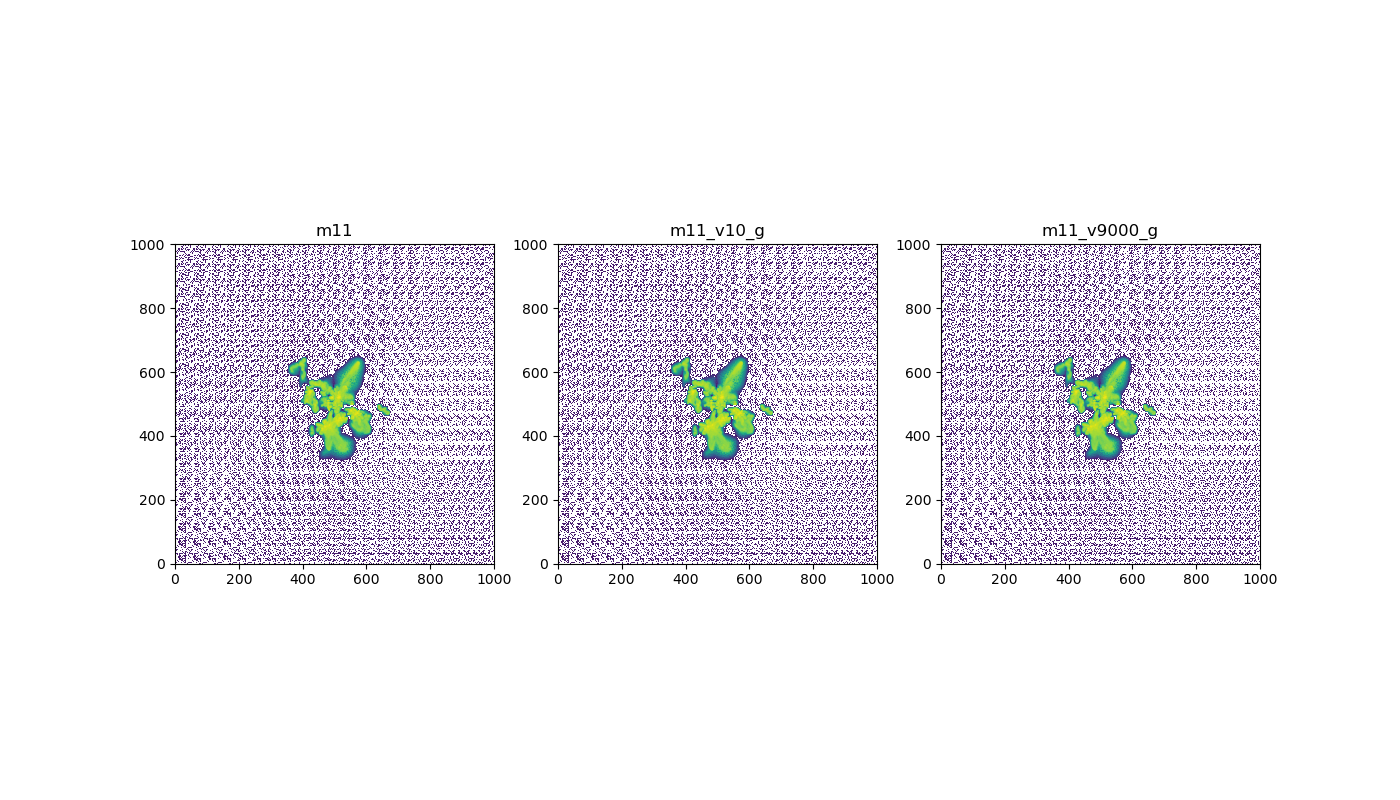

In [17]:
x1 = 0
x2 = 1000
y1 = 0
y2 = 1000

plt.figure(figsize = (14,8))
plt.subplot(131)
plt.imshow(np.nansum(m11_new_g, axis = 0),norm=colors.LogNorm(), cmap = 'viridis')#, vmin = 1e15, vmax = 1e23)
# plt.colorbar()
plt.xlim(x1,x2)
plt.ylim(y1,y2)
plt.title('m11')


plt.subplot(132)
plt.imshow(np.nansum(m11_v100_g, axis = 0),norm=colors.LogNorm(), cmap = 'viridis')#, vmin = 1e22, vmax = 1e23)
# plt.colorbar()
plt.xlim(x1,x2)
plt.ylim(y1,y2)
plt.title('m11_v10_g')

plt.subplot(133)
plt.imshow(np.nansum(m11_v9000_g, axis = 0),norm=colors.LogNorm(), cmap = 'viridis')#, vmin = 1e14, vmax = 1e18)
# plt.colorbar()
plt.xlim(x1,x2)
plt.ylim(y1,y2)
plt.title('m11_v9000_g')

In [18]:
vel = ad['PartType0', 'vel_kms']

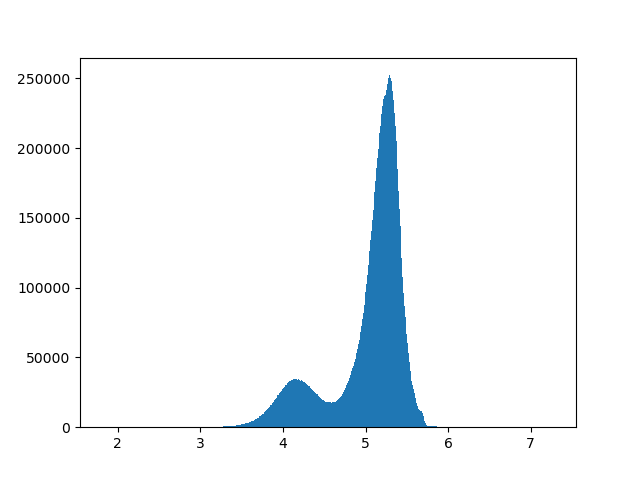

In [25]:
plt.figure()
plt.hist(np.log10(vel.value), bins = 1000)
plt.show()

## Playing around with dataset using yt

Look for fields inside the dataset

In [3]:
ds.fields

A desription of the fields is found in the gizmo documentation : http://www.tapir.caltech.edu/~phopkins/Site/GIZMO_files/gizmo_documentation.html

More information is in the STARFORGE paper: 
* https://arxiv.org/abs/2010.11254

## Creating grid using numpy histogram

### The code below creates 1d arrays of the fields

In [5]:
ad = ds.all_data()

# temp = ad['PartType0', 'Temperature']
# m11 = ad['PartType0', 'Metallicity_11']
# m12 = ad['PartType0', 'Metallicity_12']
# m13 = ad['PartType0', 'Metallicity_13']

m11_new = ad['PartType0', 'm_11']
m12_new = ad['PartType0', 'm_12']
m13_new = ad['PartType0', 'm_13']

# dens_h2 =  ad['PartType0', 'H2NumDensity']
dens_all = ad['PartType0', 'Density']

moldens = ad['PartType0',  'MolecularNumDensity']
masked_moldens = ad['PartType0',  'MaskedMolecularNumDensity']


x = ad['PartType0','Coordinates'].value[:,0]
y = ad['PartType0','Coordinates'].value[:,1]
z = ad['PartType0','Coordinates'].value[:,2]
radius = (ad["PartType0", "particle_radius"]).value * 3.2408e-19 * 10 #cm to pc #*10 to fit to current figure which is 1000*1000

### Binning/Gridding the data

In [6]:
dens_g, edges = np.histogramdd((x,y,z), bins = 1000, weights = dens_all)
m11_new_g, edges = np.histogramdd((x,y,z), bins = 1000, weights = m11_new)
moldens_g, edges = np.histogramdd((x,y,z), bins = 1000, weights = moldens)
masked_moldens_g, edges = np.histogramdd((x,y,z), bins = 1000, weights = masked_moldens)

### Plotting

Text(0.5, 1.0, 'Masked density 10% ouflow')

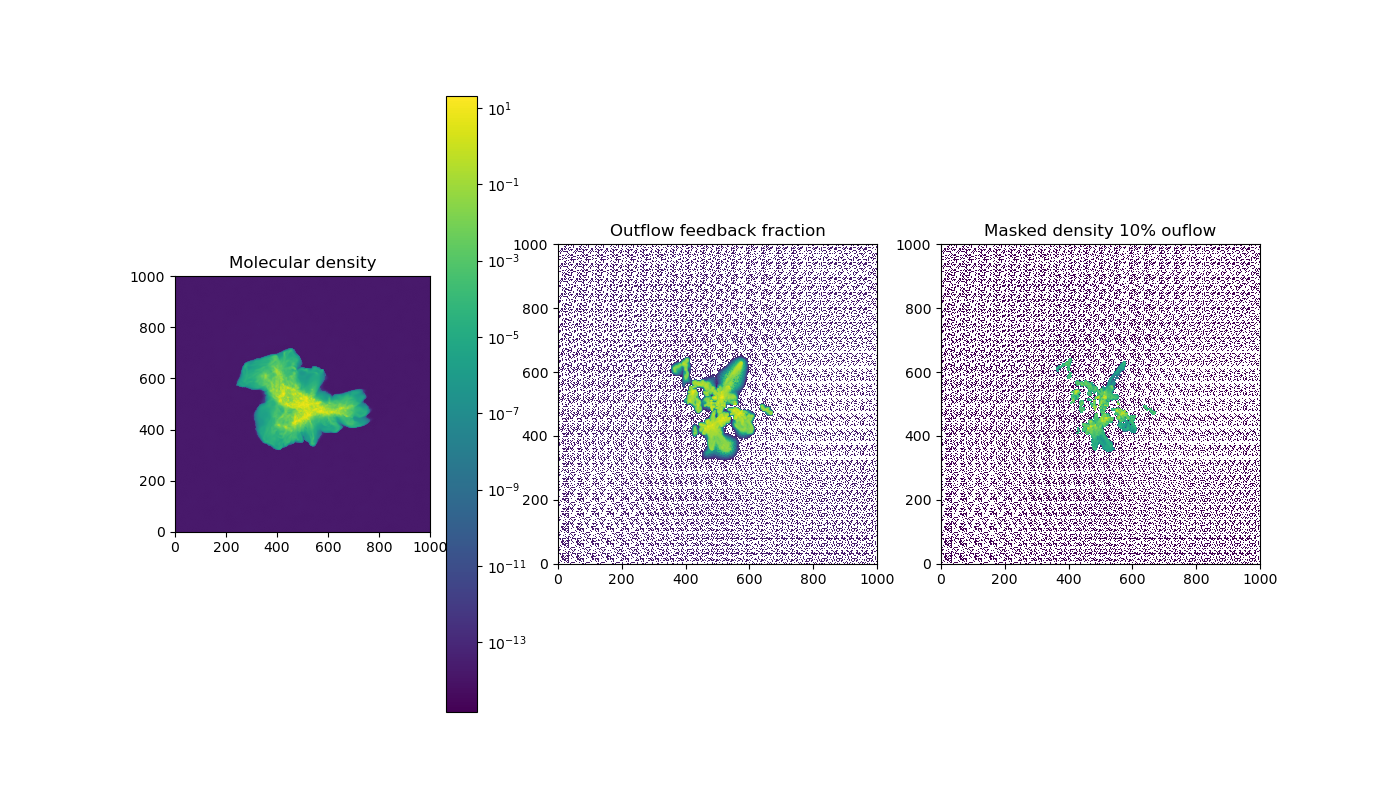

In [7]:
x1 = 0
x2 = 1000
y1 = 0
y2 = 1000

plt.figure(figsize = (14,8))
plt.subplot(131)
plt.imshow(np.nansum(moldens_g, axis = 0),norm=colors.LogNorm(), cmap = 'viridis')#, vmin = 1e15, vmax = 1e23)
plt.colorbar()
plt.xlim(x1,x2)
plt.ylim(y1,y2)
plt.title('Molecular density')


plt.subplot(132)
plt.imshow(np.nansum(m11_new_g, axis = 0),norm=colors.LogNorm(), cmap = 'viridis')#, vmin = 1e22, vmax = 1e23)
# plt.colorbar()
plt.xlim(x1,x2)
plt.ylim(y1,y2)
plt.title('Outflow feedback fraction')

plt.subplot(133)
plt.imshow(np.nansum(masked_moldens_g, axis = 0),norm=colors.LogNorm(), cmap = 'viridis')#, vmin = 1e14, vmax = 1e18)
# plt.colorbar()
plt.xlim(x1,x2)
plt.ylim(y1,y2)
plt.title('Masked density 10% ouflow')

### The below cell represents the parameters of the plot

In [7]:
x_cen = 50
y_cen = 50
z_cen = 50

widt_h = 60
widt_z = 60
widt_u = 'pc'

buff = (640,640)

box = ds.r[(x_cen - widt_h/2, widt_u):(x_cen + widt_h/2, widt_u), (y_cen - widt_h/2, widt_u):(y_cen + widt_h/2, widt_u),(z_cen - widt_z/2, widt_u):(z_cen + widt_z/2, widt_u)]

## Creating a grid for plotting using YT

In [8]:
prj0 = ds.proj(('PartType0', 'MolecularNumDensity'),axis = 0, data_source=box) #projected along x axix
frb0 = FixedResolutionBuffer(prj0, (x_cen - widt_h/2, x_cen + widt_h/2, y_cen - widt_h/2, y_cen + widt_h/2), buff)
my_image0 = frb0['PartType0', 'MolecularNumDensity']
my_image_m11 = frb0['PartType0', 'm_11']
my_image2 = frb0['PartType0', 'MaskedMolecularNumDensity']
# my_image3 = frb0['PartType0', 'H2NumDensity']
# my_image_temp = frb0['PartType0', 'gas_temperature']

yt : [INFO     ] 2024-05-10 10:54:03,229 Making a fixed resolution buffer of (('PartType0', 'MolecularNumDensity')) 640 by 640
yt : [INFO     ] 2024-05-10 10:54:44,919 Making a fixed resolution buffer of (('PartType0', 'm_11')) 640 by 640
yt : [INFO     ] 2024-05-10 10:55:19,865 Making a fixed resolution buffer of (('PartType0', 'MaskedMolecularNumDensity')) 640 by 640


### Plotting

Specify the coordinates (x1,x2,y1,y2) of all plots manually if needed -- the maximum values depend on the buff parameter


Text(0.5, 1.0, 'Masked density 10% ouflow')

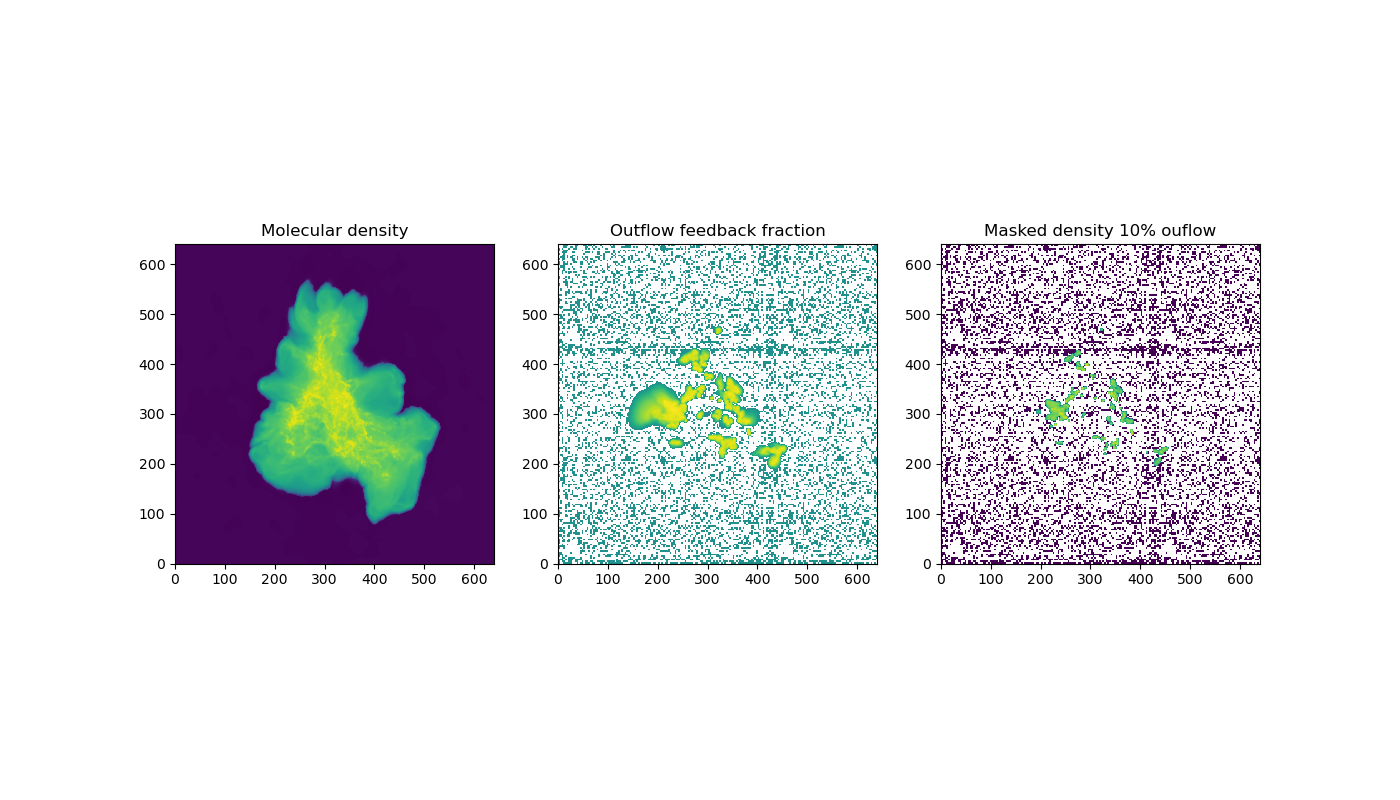

In [10]:
x1 = 0
x2 = 640
y1 = 0
y2 = 640

plt.figure(figsize = (14,8))
plt.subplot(131)
plt.imshow(my_image0,norm=colors.LogNorm(), cmap = 'viridis')#, vmin = 1e15, vmax = 1e23)
# plt.colorbar()
plt.xlim(x1,x2)
plt.ylim(y1,y2)
plt.title('Molecular density')


plt.subplot(132)
plt.imshow(my_image_m11,norm=colors.LogNorm(), cmap = 'viridis')#, vmin = 1e22, vmax = 1e23)
# plt.colorbar()
plt.xlim(x1,x2)
plt.ylim(y1,y2)
plt.title('Outflow feedback fraction')

plt.subplot(133)
plt.imshow(my_image2,norm=colors.LogNorm(), cmap = 'viridis')#, vmin = 1e14, vmax = 1e18)
# plt.colorbar()
plt.xlim(x1,x2)
plt.ylim(y1,y2)
plt.title('Masked density 10% ouflow')

## 3D plotting

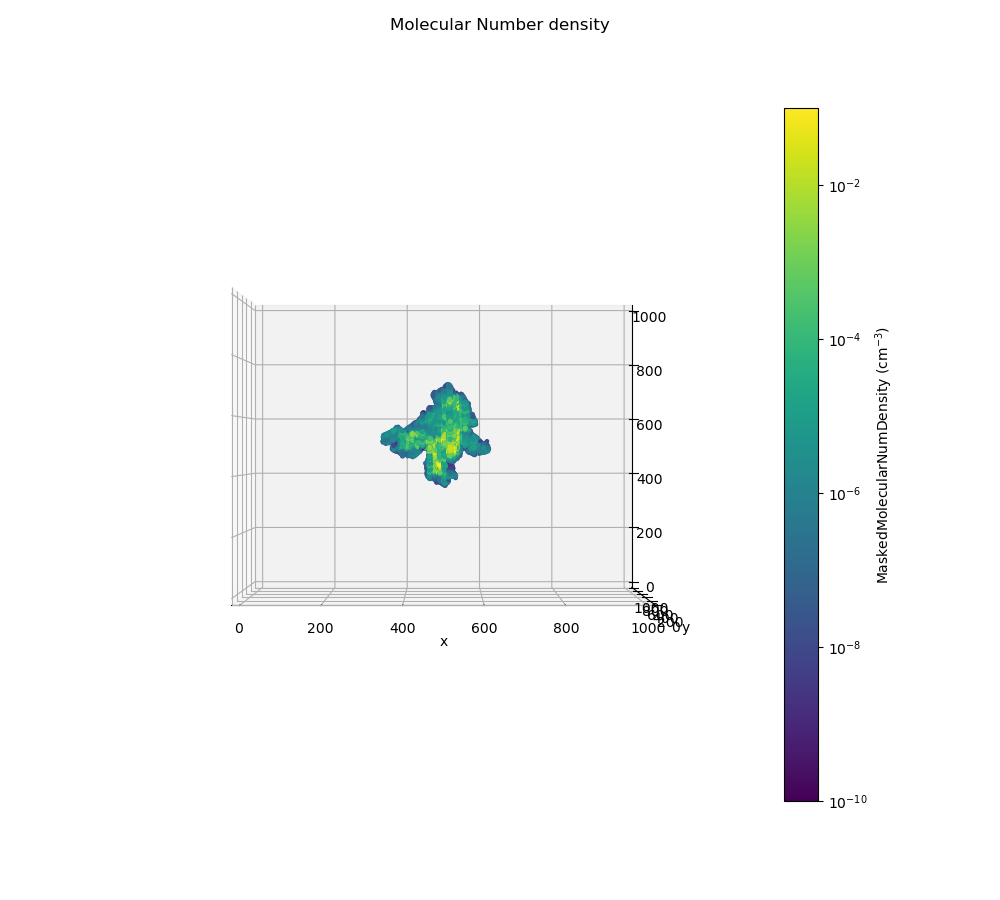

In [11]:
prop = moldens_g #select the property to plot --> from the gridded properties above
propname = 'Molecular Number density'

y_slc = 500 # for sliceplot
yr1 = 480 # for partial projection
yr2 = 520 # for partial projection

plotname = 'slice' 
# plotname = 'proj' 
# plotname = 'partproj'

#--------------------------------------------------------------------

prop_flat = prop.flatten()
x = y = z = np.arange(prop.shape[0])#according to resolution of the grids when created
x,y,z = np.meshgrid(x,y,z, indexing = 'ij')
x= x.flatten()
y = y.flatten()
z = z.flatten()

## WHICH PLOT?

if plotname == 'slice':
    x1 = x[(prop_flat > 1e-10) & (y == y_slc)]
    y1 = y[(prop_flat > 1e-10) & (y == y_slc)]
    z1 = z[(prop_flat > 1e-10) & (y == y_slc)]
    prop_2 = prop_flat[(prop_flat > 1e-10) & (y == y_slc)] 


if plotname == 'partproj':
    x1 = x[(prop_flat > 1e-10) & (x > yr1) & (x < yr2)]
    y1 = y[(prop_flat > 1e-10) & (x > yr1) & (x < yr2)]
    z1 = z[(prop_flat > 1e-10) & (x > yr1) & (x < yr2)]
    prop_2 = prop_flat[(prop_flat > 1e-10) & (x > yr1) & (x < yr2)]


if plotname == 'proj':
    x1 = x[(prop_flat > 1e-10)]
    y1 = y[(prop_flat > 1e-10)]
    z1 = z[(prop_flat > 1e-10)]
    prop_2 = prop_flat[(prop_flat > 1e-10)] 
    
fig = plt.figure(figsize = (10,9))
ax = fig.add_subplot(1,1,1,projection='3d')
scatter = ax.scatter(x1,y1,z1, c = prop_2, marker = '.', cmap = 'viridis', norm=LogNorm(vmin=1e-10, vmax=1e-1))
plt.colorbar(scatter, label = 'MaskedMolecularNumDensity (cm$^{-3}$)')
plt.suptitle(propname)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0,1000)
plt.ylim(0,1000)
ax.set_zlim(0,1000)
ax.view_init(elev=0, azim=270)
plt.show()